<a href="https://colab.research.google.com/github/RanaRoc/gymAnalysis/blob/main/Projet_prediction_elec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet prédiction prix de l'électricité







Aperçu des données d'entraînement
              DELIVERY_START  load_forecast  coal_power_available  \
0  2022-01-01 02:00:00+01:00        49439.0                3386.0   
1  2022-01-01 03:00:00+01:00        46511.0                3386.0   
2  2022-01-01 04:00:00+01:00        45158.0                3386.0   
3  2022-01-01 05:00:00+01:00        44779.0                3386.0   
4  2022-01-01 06:00:00+01:00        45284.0                3386.0   

   gas_power_available  nucelear_power_available  \
0              11487.0                   44118.0   
1              11487.0                   44118.0   
2              11487.0                   44118.0   
3              11487.0                   44118.0   
4              11487.0                   44118.0   

   wind_power_forecasts_average  solar_power_forecasts_average  \
0                        3035.0                            0.0   
1                        3143.0                            0.0   
2                        3288.0         

C:\Users\Ranar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Explicabilité - Random Forest


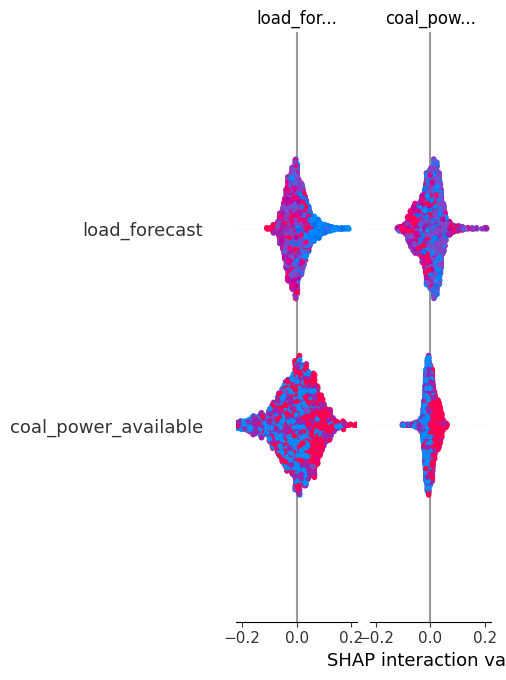

Explicabilité - Gradient Boosting


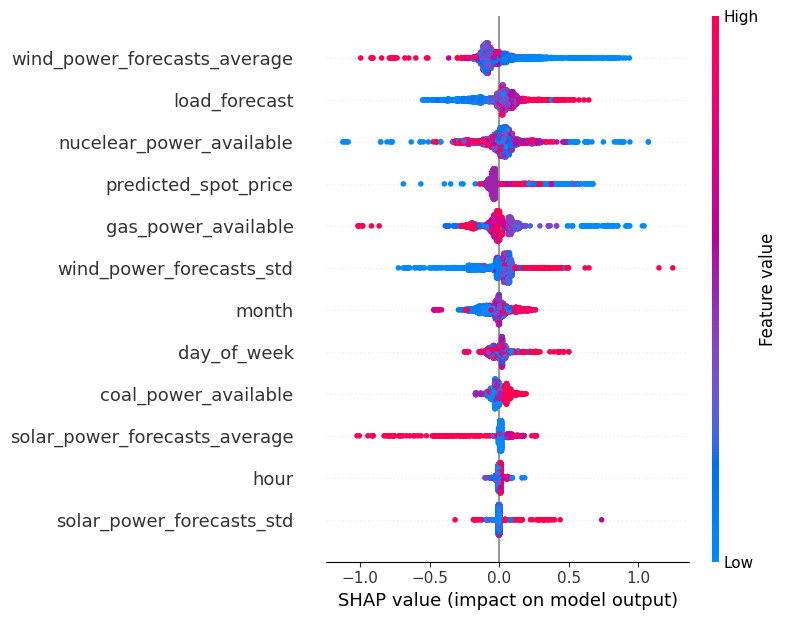

Explicabilité - XGBoost


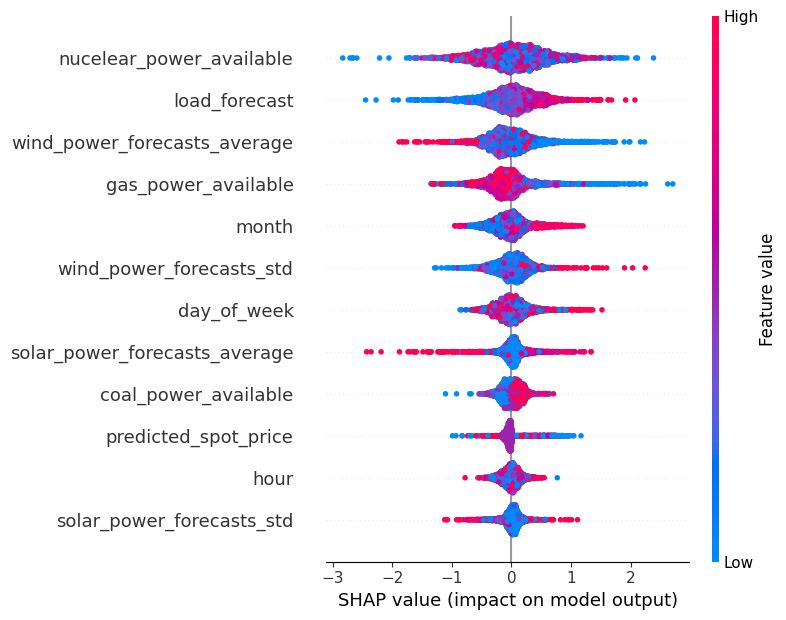

Prédictions sur les données de test
Régression Logistique : [1 1 1 ... 0 0 0]
Random Forest : [0 0 0 ... 0 1 1]
Gradient Boosting : [0 0 0 ... 1 1 1]
XGBoost : [0 0 0 ... 1 0 0]


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import shap
import xgboost as xgb

X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')  # Correcting to y_test for clarity

print("Aperçu des données d'entraînement")
print(X_train.head())
print(y_train.head())

X_train['DELIVERY_START'] = pd.to_datetime(X_train['DELIVERY_START'], utc=True)
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], utc=True)

assert pd.api.types.is_datetime64_any_dtype(X_train['DELIVERY_START']), "DELIVERY_START n'est pas au format datetime."
assert pd.api.types.is_datetime64_any_dtype(X_test['DELIVERY_START']), "DELIVERY_START n'est pas au format datetime."

for df in [X_train, X_test]:
    df['hour'] = df['DELIVERY_START'].dt.hour
    df['day_of_week'] = df['DELIVERY_START'].dt.dayofweek
    df['month'] = df['DELIVERY_START'].dt.month

numeric_columns_train = X_train.select_dtypes(include=[np.number]).columns
numeric_columns_test = X_test.select_dtypes(include=[np.number]).columns

X_train[numeric_columns_train] = X_train[numeric_columns_train].fillna(X_train[numeric_columns_train].median())
X_test[numeric_columns_test] = X_test[numeric_columns_test].fillna(X_test[numeric_columns_test].median())

assert not X_train[numeric_columns_train].isnull().any().any(), "Des NaN subsistent dans X_train après le remplissage."
assert not X_test[numeric_columns_test].isnull().any().any(), "Des NaN subsistent dans X_test après le remplissage."

y_train['direction'] = (y_train['spot_id_delta'] > 0).astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns_train])
X_test_scaled = scaler.transform(X_test[numeric_columns_test])

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train['direction'], test_size=0.3, random_state=42
)

assert not np.isnan(X_train_split).any(), "X_train_split contient des NaN."
assert not np.isnan(X_val).any(), "X_val contient des NaN."

log_model = LogisticRegression(random_state=42, max_iter=1000)
param_grid_log = {'C': [0.01, 0.1, 1, 10]}
grid_log = GridSearchCV(log_model, param_grid_log, cv=5, scoring='accuracy')
grid_log.fit(X_train_split, y_train_split)
log_model_best = grid_log.best_estimator_

y_pred_log = log_model_best.predict(X_val)
accuracy_log = accuracy_score(y_val, y_pred_log)
print(f"Accuracy - Régression Logistique : {accuracy_log:.2f}")

rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_split, y_train_split)
rf_model_best = grid_rf.best_estimator_

y_pred_rf = rf_model_best.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy - Random Forest : {accuracy_rf:.2f}")

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_split, y_train_split)

y_pred_gb = gb_model.predict(X_val)
accuracy_gb = accuracy_score(y_val, y_pred_gb)
print(f"Accuracy - Gradient Boosting : {accuracy_gb:.2f}")

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_split, y_train_split)

y_pred_xgb = xgb_model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy - XGBoost : {accuracy_xgb:.2f}")

def weighted_accuracy(y_true, y_pred, spot_id_delta):
    weights = np.abs(spot_id_delta)
    correct = (y_true == y_pred).astype(int)
    weighted_correct = correct * weights
    return weighted_correct.sum() / weights.sum()

weighted_acc_log = weighted_accuracy(
    y_val, y_pred_log, y_train.loc[y_val.index, 'spot_id_delta']
)
weighted_acc_rf = weighted_accuracy(
    y_val, y_pred_rf, y_train.loc[y_val.index, 'spot_id_delta']
)
weighted_acc_gb = weighted_accuracy(
    y_val, y_pred_gb, y_train.loc[y_val.index, 'spot_id_delta']
)
weighted_acc_xgb = weighted_accuracy(
    y_val, y_pred_xgb, y_train.loc[y_val.index, 'spot_id_delta']
)

print(f"Weighted Accuracy - Régression Logistique : {weighted_acc_log:.2f}")
print(f"Weighted Accuracy - Random Forest : {weighted_acc_rf:.2f}")
print(f"Weighted Accuracy - Gradient Boosting : {weighted_acc_gb:.2f}")
print(f"Weighted Accuracy - XGBoost : {weighted_acc_xgb:.2f}")

explainer_rf = shap.TreeExplainer(rf_model_best)
shap_values_rf = explainer_rf.shap_values(X_val)

explainer_gb = shap.TreeExplainer(gb_model)
shap_values_gb = explainer_gb.shap_values(X_val)

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_val)

print("Explicabilité - Random Forest")
shap.summary_plot(shap_values_rf, X_val, feature_names=numeric_columns_train)

print("Explicabilité - Gradient Boosting")
shap.summary_plot(shap_values_gb, X_val, feature_names=numeric_columns_train)

print("Explicabilité - XGBoost")
shap.summary_plot(shap_values_xgb, X_val, feature_names=numeric_columns_train)

y_test_pred_log = log_model_best.predict(X_test_scaled)
y_test_pred_rf = rf_model_best.predict(X_test_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

print("Prédictions sur les données de test")
print(f"Régression Logistique : {y_test_pred_log}")
print(f"Random Forest : {y_test_pred_rf}")
print(f"Gradient Boosting : {y_test_pred_gb}")
print(f"XGBoost : {y_test_pred_xgb}")


In [28]:
new_data = {
    'DELIVERY_START': ['2025-01-20T12:00:00Z'],
    'load_forecast': [55000],
    'coal_power_available': [12000],
    'gas_power_available': [15000],
    'nucelear_power_available': [40000],
    'wind_power_forecasts_average': [8000],
    'solar_power_forecasts_average': [3000],
    'wind_power_forecasts_std': [500],
    'solar_power_forecasts_std': [200],
    'predicted_spot_price': [80]
}

new_data_df = pd.DataFrame(new_data)

new_data_df['DELIVERY_START'] = pd.to_datetime(new_data_df['DELIVERY_START'], utc=True)
new_data_df['hour'] = new_data_df['DELIVERY_START'].dt.hour
new_data_df['day_of_week'] = new_data_df['DELIVERY_START'].dt.dayofweek
new_data_df['month'] = new_data_df['DELIVERY_START'].dt.month

new_data_scaled = scaler.transform(new_data_df[numeric_columns_train])

new_pred_log = log_model_best.predict(new_data_scaled)
new_pred_rf = rf_model_best.predict(new_data_scaled)
new_pred_gb = gb_model.predict(new_data_scaled)
new_pred_xgb = xgb_model.predict(new_data_scaled)

print("Prédictions pour les nouvelles données :")
print(f"Régression Logistique : {'Intraday > SPOT' if new_pred_log[0] == 1 else 'SPOT > Intraday'}")
print(f"Random Forest : {'Intraday > SPOT' if new_pred_rf[0] == 1 else 'SPOT > Intraday'}")
print(f"Gradient Boosting : {'Intraday > SPOT' if new_pred_gb[0] == 1 else 'SPOT > Intraday'}")
print(f"XGBoost : {'Intraday > SPOT' if new_pred_xgb[0] == 1 else 'SPOT > Intraday'}")


Prédictions pour les nouvelles données :
Régression Logistique : Intraday > SPOT
Random Forest : Intraday > SPOT
Gradient Boosting : Intraday > SPOT
XGBoost : Intraday > SPOT


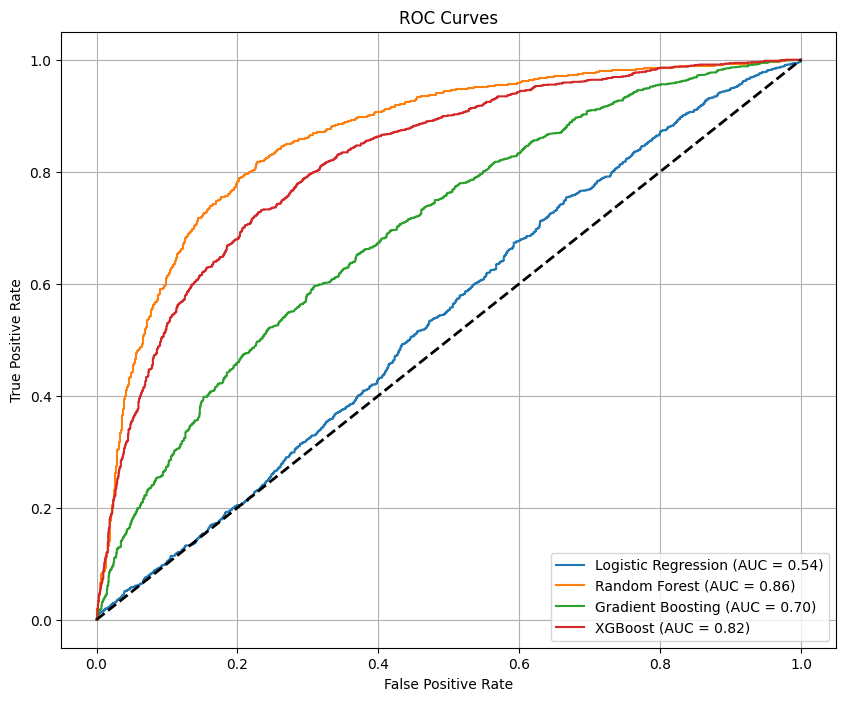

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": log_model_best,
    "Random Forest": rf_model_best,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model
}

plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()
